# 6. Feature Engineering, Dimensionality Reduction & Model Retraining

**Purpose:** Implement TA recommendations to improve poverty prediction model.

**Key Changes from Previous Notebooks:**
1. **Disability Aggregate** - Replace binary `DIS` with severity score from 6 individual disability indicators
2. **Health Insurance Collapse** - Replace 3 insurance features with single binary (has/doesn't have)
3. **Race/Ethnicity Overhaul** - One-hot encode collapsed race categories + HISP ethnicity (no more label encoding)
4. **Education Tiers** - Replace ordinal SCHL with meaningful 5-level tier
5. **Dimensionality Reduction** - Elbow plot & feature importance to select optimal feature count
6. **Stratified K-Fold CV** - Cross-validation with resampling per fold
7. **Use Case Framing** - Recall-focused evaluation for social intervention pre-screening

**Data Source:** Raw `persons_master.csv` (to access all 274 columns including individual disability/race flags)

---
## Hypothetical Use Case

**Scenario:** A California state agency wants a pre-screening tool to identify households in poverty or at risk of falling below the poverty line, so they can proactively offer social services (housing assistance, job training, healthcare enrollment) before families slide further into poverty.

**Implication for Metrics:**
- **Prioritize Recall** — It's worse to miss a family that needs help (false negative) than to flag one that doesn't (false positive)
- **Primary Metric:** F1 Score (balances precision and recall for imbalanced data)
- **Secondary Metric:** Recall for At-Risk class
- **Minimum Bar:** Must outperform a 50/50 coin toss (i.e., better than random)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    classification_report, confusion_matrix, f1_score,
    precision_recall_curve, balanced_accuracy_score, ConfusionMatrixDisplay,
    recall_score
)
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import xgboost as xgb
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 50)
print('Libraries loaded.')

Libraries loaded.


---
## Phase 1: Load Raw Data & Recreate Base Variables

In [2]:
# Load raw master dataset (all 274 columns)
df_raw = pd.read_csv('../1_Raw_Data/data_persons_ca_1yr/persons_master.csv')
print(f'Raw data shape: {df_raw.shape}')
print(f'Years present: {sorted(df_raw["year"].unique())}')
print(f'Age range: {df_raw["AGEP"].min()} - {df_raw["AGEP"].max()}')

Raw data shape: (1842394, 275)
Years present: [np.int64(2018), np.int64(2019), np.int64(2021), np.int64(2022), np.int64(2023), np.int64(2024)]
Age range: 19 - 94


In [3]:
# Filter to adults only (age > 18) — consistent with previous notebooks
df = df_raw[df_raw['AGEP'] > 18].copy()
print(f'Adults only: {df.shape}')

Adults only: (1842394, 275)


In [4]:
# Recreate poverty_risk_score (same logic as EDA)
def categorize_poverty_score(val):
    if pd.isna(val): return None
    if val <= 50: return 3      # Deep Poverty
    if val <= 100: return 2     # Poverty
    if val <= 200: return 1     # Near Poverty
    return 0                    # Stable

df['poverty_risk_score'] = df['POVPIP'].apply(categorize_poverty_score)

# Drop rows with no poverty score
df = df.dropna(subset=['poverty_risk_score'])
df['poverty_risk_score'] = df['poverty_risk_score'].astype(int)

# Binary target: Stable (0) vs At-Risk (1)
df['binary_target'] = (df['poverty_risk_score'] > 0).astype(int)

print('Target distribution (4-class):')
print(df['poverty_risk_score'].value_counts().sort_index())
print(f'\nBinary target distribution:')
print(df['binary_target'].value_counts())

Target distribution (4-class):
poverty_risk_score
0    1348539
1     235039
2      94529
3      96030
Name: count, dtype: int64

Binary target distribution:
binary_target
0    1348539
1     425598
Name: count, dtype: int64


In [5]:
# Recreate CA_Region (same logic as EDA)
def map_puma_to_region(puma):
    if pd.isna(puma): return 'Unknown'
    p = int(puma)
    if p < 1500: return 'Northern CA/Sierras'
    if 1500 <= p < 3000: return 'Bay Area'
    if 3000 <= p < 5000: return 'Central Valley'
    if 5000 <= p < 7000: return 'Central Coast'
    if 7000 <= p < 9000: return 'Los Angeles'
    if 9000 <= p < 10000: return 'Inland Empire'
    if p >= 10000: return 'San Diego/Border'
    return 'Unknown'

df['CA_Region'] = df['PUMA'].apply(map_puma_to_region)
print('Region distribution:')
print(df['CA_Region'].value_counts())

Region distribution:
CA_Region
Central Valley         510957
Los Angeles            488297
Central Coast          373489
Northern CA/Sierras    155818
Bay Area               102561
San Diego/Border        77098
Inland Empire           65917
Name: count, dtype: int64


---
## Phase 2: Feature Engineering

### 2a. Disability Aggregate

**Previous approach:** Binary `DIS` (has disability vs. doesn't)  
**New approach:** Sum of 6 individual disability indicators → severity score (0-6)

Available ACS disability fields:
- `DEAR` - Hearing difficulty (1=Yes, 2=No)
- `DEYE` - Vision difficulty (1=Yes, 2=No)
- `DPHY` - Ambulatory difficulty (1=Yes, 2=No, 0=N/A under 5)
- `DREM` - Cognitive difficulty (1=Yes, 2=No, 0=N/A under 5)
- `DDRS` - Self-care difficulty (1=Yes, 2=No, 0=N/A under 5)
- `DOUT` - Independent living difficulty (1=Yes, 2=No, 0=N/A under 15)

In [6]:
# Create disability severity score (0-6)
# counts how many co-occurring disabilities someone has. A score of 3 just means "has 3 different disabilities." So the model learns that more comorbidities = higher poverty risk
disability_cols = ['DEAR', 'DEYE', 'DPHY', 'DREM', 'DDRS', 'DOUT']

# Check raw values
for col in disability_cols:
    print(f'{col}: {df[col].value_counts().sort_index().to_dict()}')

DEAR: {1: 76527, 2: 1697610}
DEYE: {1: 46762, 2: 1727375}
DPHY: {1.0: 137421, 2.0: 1636716}
DREM: {1.0: 93766, 2.0: 1680371}
DDRS: {1.0: 59726, 2.0: 1714411}
DOUT: {1.0: 112975, 2.0: 1661162}


In [7]:
# Convert: 1=Yes (has difficulty) → 1, 2=No → 0, 0=N/A → 0
for col in disability_cols:
    df[f'{col}_binary'] = (df[col] == 1).astype(int)

# Sum into disability severity score
df['disability_score'] = df[[f'{c}_binary' for c in disability_cols]].sum(axis=1)

print('Disability severity score distribution:')
print(df['disability_score'].value_counts().sort_index())
print(f'\nCorrelation with poverty_risk_score: {df["disability_score"].corr(df["poverty_risk_score"]):.4f}')
print(f'Correlation with POVPIP: {df["disability_score"].corr(df["POVPIP"]):.4f}')

# Compare to original binary DIS
print(f'\nOriginal DIS correlation with POVPIP: {(df["DIS"] == 1).astype(int).corr(df["POVPIP"]):.4f}')

Disability severity score distribution:
disability_score
0    1511749
1     130064
2      56506
3      37024
4      25049
5       9637
6       4108
Name: count, dtype: int64

Correlation with poverty_risk_score: 0.1401
Correlation with POVPIP: -0.1574

Original DIS correlation with POVPIP: -0.1527


### 2b. Health Insurance Collapse

**Previous approach:** 3 features — `HICOV`, `PRIVCOV`, `PUBCOV` (PRIVCOV dominated at 0.32 importance)  
**New approach:** Single binary — has any insurance (1) vs. no insurance (0)

**Rationale:** In California, Medi-Cal qualification requires being at or below the poverty line. Keeping PRIVCOV/PUBCOV separately may introduce quasi-data-leakage since public insurance status is essentially a proxy for poverty status.

In [8]:
# Check original insurance values
# ACS: 1=Yes (has coverage), 2=No (no coverage)
print('HICOV (any insurance):', df['HICOV'].value_counts().sort_index().to_dict())
print('PRIVCOV (private):', df['PRIVCOV'].value_counts().sort_index().to_dict())
print('PUBCOV (public):', df['PUBCOV'].value_counts().sort_index().to_dict())

HICOV (any insurance): {1: 1659142, 2: 114995}
PRIVCOV (private): {1: 1187345, 2: 586792}
PUBCOV (public): {1: 722283, 2: 1051854}


In [9]:
# Collapse to single binary: has_insurance (1=has any, 0=uninsured)
# HICOV: 1=has coverage, 2=no coverage
df['has_insurance'] = (df['HICOV'] == 1).astype(int)

print('has_insurance distribution:')
print(df['has_insurance'].value_counts())
print(f'\nCorrelation with POVPIP: {df["has_insurance"].corr(df["POVPIP"]):.4f}')

# Compare correlations
print(f'\n--- Correlation comparison with POVPIP ---')
print(f'has_insurance (new):  {df["has_insurance"].corr(df["POVPIP"]):.4f}')
print(f'PRIVCOV (old):        {(df["PRIVCOV"] == 1).astype(int).corr(df["POVPIP"]):.4f}')
print(f'PUBCOV (old):         {(df["PUBCOV"] == 1).astype(int).corr(df["POVPIP"]):.4f}')
print(f'HICOV (old):          {(df["HICOV"] == 1).astype(int).corr(df["POVPIP"]):.4f}')

has_insurance distribution:
has_insurance
1    1659142
0     114995
Name: count, dtype: int64

Correlation with POVPIP: 0.1566

--- Correlation comparison with POVPIP ---
has_insurance (new):  0.1566
PRIVCOV (old):        0.4329
PUBCOV (old):         -0.2917
HICOV (old):          0.1566


### 2c. Race/Ethnicity Overhaul

**Previous approach:** `RAC1P` label-encoded (1-9 → 0-8 integer). This is **problematic** because the model treats higher numeric values as more influential.

**New approach:**
1. Collapse to 5 race categories: White, Black, Asian, Indigenous, Other
2. Add `HISP` as binary Latinx ethnicity indicator
3. One-hot encode the 5 race categories
4. Create **racial-ethnic aggregate** (sum of one-hot values → captures multiracial identities)

The raw data has individual race flags: `RACWHT`, `RACBLK`, `RACASN`, `RACAIAN`, `RACNH`, `RACPI`, `RACSOR` — these are already binary (0/1).

In [10]:
# Check individual race flags in raw data
race_binary_cols = ['RACWHT', 'RACBLK', 'RACASN', 'RACAIAN', 'RACNH', 'RACPI', 'RACSOR']
print('Individual race flag distributions:')
for col in race_binary_cols:
    print(f'  {col}: {df[col].value_counts().sort_index().to_dict()}')

# Check HISP (Latinx ethnicity)
print(f'\nHISP unique values: {df["HISP"].nunique()}')
print(f'HISP == 1 (Not Hispanic): {(df["HISP"] == 1).sum()}')
print(f'HISP > 1 (Hispanic/Latino): {(df["HISP"] > 1).sum()}')

Individual race flag distributions:
  RACWHT: {0: 691477, 1: 1082660}
  RACBLK: {0: 1678869, 1: 95268}
  RACASN: {0: 1424899, 1: 349238}
  RACAIAN: {0: 1720050, 1: 54087}
  RACNH: {0: 1770584, 1: 3553}
  RACPI: {0: 1765309, 1: 8828}
  RACSOR: {0: 1370646, 1: 403491}

HISP unique values: 24
HISP == 1 (Not Hispanic): 1199950
HISP > 1 (Hispanic/Latino): 574187


In [11]:
# Collapse to 5 race categories using raw binary flags
# White, Black, Asian, Indigenous (AIAN + NH + PI), Other (SOR)
df['race_white'] = df['RACWHT']
df['race_black'] = df['RACBLK']
df['race_asian'] = df['RACASN']
df['race_indigenous'] = ((df['RACAIAN'] == 1) | (df['RACNH'] == 1) | (df['RACPI'] == 1)).astype(int)
df['race_other'] = df['RACSOR']

# Binary Latinx ethnicity (HISP: 1=Not Hispanic, 2+=Hispanic/Latino)
df['is_latinx'] = (df['HISP'] > 1).astype(int)

# Racial-ethnic aggregate: sum of all race + ethnicity flags
# Captures multiracial identities (e.g., half Black + half White + Latinx = score of 3)
race_ohe_cols = ['race_white', 'race_black', 'race_asian', 'race_indigenous', 'race_other', 'is_latinx']
df['race_ethnic_aggregate'] = df[race_ohe_cols].sum(axis=1)

print('Race one-hot distribution:')
for col in race_ohe_cols:
    print(f'  {col}: {df[col].sum():,} ({df[col].mean()*100:.1f}%)')

print(f'\nRacial-ethnic aggregate distribution:')
print(df['race_ethnic_aggregate'].value_counts().sort_index())

Race one-hot distribution:
  race_white: 1,082,660 (61.0%)
  race_black: 95,268 (5.4%)
  race_asian: 349,238 (19.7%)
  race_indigenous: 65,843 (3.7%)
  race_other: 403,491 (22.7%)
  is_latinx: 574,187 (32.4%)

Racial-ethnic aggregate distribution:
race_ethnic_aggregate
1    1141930
2     477720
3     145465
4       8253
5        704
6         65
Name: count, dtype: int64


In [12]:
# Correlation of new race features with POVPIP
print('Correlation of race/ethnicity features with POVPIP:')
for col in race_ohe_cols + ['race_ethnic_aggregate']:
    corr = df[col].corr(df['POVPIP'])
    print(f'  {col}: {corr:.4f}')

print(f'\nOriginal RAC1P correlation: {df["RAC1P"].corr(df["POVPIP"]):.4f}')

Correlation of race/ethnicity features with POVPIP:
  race_white: 0.0951
  race_black: -0.0538
  race_asian: 0.0780
  race_indigenous: -0.0306
  race_other: -0.1713
  is_latinx: -0.2155
  race_ethnic_aggregate: -0.1697

Original RAC1P correlation: -0.1181


### 2d. Education Tiers

**Previous approach:** Raw `SCHL` kept as ordinal (1-24)  
**New approach:** 5-level education tier (0-4)

ACS SCHL codes:
- 1-15: No high school diploma
- 16-17: High school diploma / GED
- 18-20: Some college / Associate's
- 21: Bachelor's degree
- 22-24: Advanced degree (Master's, Professional, Doctorate)

In [13]:
# Create 5-level education tier (0-4)
def education_tier(schl):
    if pd.isna(schl) or schl <= 15: return 0  # No HS diploma (some high school)
    if schl <= 17: return 1                     # HS diploma / GED
    if schl <= 20: return 2                     # Some college / Associate's
    if schl == 21: return 3                     # Bachelor's degree
    return 4                                     # Advanced degree (Master's/Prof/Doctorate)

df['education_tier'] = df['SCHL'].apply(education_tier)

print('Education tier distribution:')
tier_labels = {0: 'No HS', 1: 'HS/GED', 2: 'Some College/Assoc', 3: "Bachelor's", 4: 'Advanced'}
for tier, label in tier_labels.items():
    count = (df['education_tier'] == tier).sum()
    print(f'  {tier} ({label}): {count:,} ({count/len(df)*100:.1f}%)')

print(f'\nCorrelation with POVPIP: {df["education_tier"].corr(df["POVPIP"]):.4f}')
print(f'Original SCHL correlation: {df["SCHL"].corr(df["POVPIP"]):.4f}')

Education tier distribution:
  0 (No HS): 239,371 (13.5%)
  1 (HS/GED): 357,677 (20.2%)
  2 (Some College/Assoc): 513,034 (28.9%)
  3 (Bachelor's): 405,764 (22.9%)
  4 (Advanced): 258,291 (14.6%)

Correlation with POVPIP: 0.3847
Original SCHL correlation: 0.3339


### 2e. Additional Cleanup

Clean up remaining features:
- Keep employment features (`ESR`, `WKHP`, `WKL`, `WRK`, `OCCP`)
- Keep demographics (`AGEP`, `CIT`, `MAR`, `MSP`, `NATIVITY`, `SEX`, `MIG`)
- Keep language features (`ENG`, `LANX`) — drop `LANP` (57% null, high cardinality)
- Keep geography (`PUMA`, `CA_Region`)
- Drop `POBP` (high cardinality place of birth — 200+ values)
- Drop `year` (proven no temporal drift — adds noise)

In [14]:
# Define new feature set
# Engineered features
engineered_features = [
    'disability_score',      # Replaces DIS (0-6 severity)
    'has_insurance',         # Replaces HICOV, PRIVCOV, PUBCOV
    'race_white',            # One-hot race (replaces RAC1P)
    'race_black',
    'race_asian',
    'race_indigenous',
    'race_other',
    'is_latinx',             # Separate ethnicity flag
    'race_ethnic_aggregate', # Captures multiracial identities
    'education_tier',        # Replaces SCHL (0-4)
]

# Kept original features (unchanged)
kept_features = [
    'AGEP',       # Age (numeric)
    'CIT',        # Citizenship status
    'ENG',        # English ability
    'LANX',       # Language other than English
    'MAR',        # Marital status
    'MIG',        # Mobility status
    'MSP',        # Married, spouse present
    'SEX',        # Sex
    'NATIVITY',   # Nativity
    'ESR',        # Employment status
    'OCCP',       # Occupation
    'WKHP',       # Hours worked per week (numeric)
    'WKL',        # When last worked
    'WRK',        # Worked last week
    'PUMA',       # Public use microdata area
    'CA_Region',  # California region
]

# Dropped (with reasons)
dropped_features = {
    'DIS':      'Replaced by disability_score (0-6)',
    'HICOV':    'Replaced by has_insurance (binary)',
    'PRIVCOV':  'Replaced by has_insurance (binary) — was 0.32 importance, possible quasi-leakage',
    'PUBCOV':   'Replaced by has_insurance (binary) — Medi-Cal requires poverty-level income',
    'RAC1P':    'Replaced by one-hot race columns — label encoding was methodologically wrong',
    'SCHL':     'Replaced by education_tier (0-4)',
    'LANP':     'Dropped — 57% null, high cardinality (200+ languages)',
    'POBP':     'Dropped — high cardinality (200+ places of birth)',
    'year':     'Dropped — no temporal drift proven in notebook 4b',
}

all_features = engineered_features + kept_features

print(f'Total features: {len(all_features)}')
print(f'  Engineered: {len(engineered_features)}')
print(f'  Kept original: {len(kept_features)}')
print(f'  Dropped: {len(dropped_features)}')
print(f'\nDropped features and reasons:')
for feat, reason in dropped_features.items():
    print(f'  {feat}: {reason}')

Total features: 26
  Engineered: 10
  Kept original: 16
  Dropped: 9

Dropped features and reasons:
  DIS: Replaced by disability_score (0-6)
  HICOV: Replaced by has_insurance (binary)
  PRIVCOV: Replaced by has_insurance (binary) — was 0.32 importance, possible quasi-leakage
  PUBCOV: Replaced by has_insurance (binary) — Medi-Cal requires poverty-level income
  RAC1P: Replaced by one-hot race columns — label encoding was methodologically wrong
  SCHL: Replaced by education_tier (0-4)
  LANP: Dropped — 57% null, high cardinality (200+ languages)
  POBP: Dropped — high cardinality (200+ places of birth)
  year: Dropped — no temporal drift proven in notebook 4b


---
## Phase 3: Null Handling & Preprocessing

In [15]:
# ACS-compliant null handling (same logic as notebook 4, applied to raw data)

# ENG: 0 = N/A for English-only speakers
df['ENG'] = df['ENG'].fillna(0)

# WKHP: 0 = did not work
df['WKHP'] = df['WKHP'].fillna(0)

# WRK: 0 = not reported / N/A
df['WRK'] = df['WRK'].fillna(0)

# OCCP: "NILF" for unemployed / not in labor force
df['OCCP'] = df['OCCP'].fillna('NILF')

# Check for remaining nulls in our feature set
feature_df = df[all_features + ['poverty_risk_score', 'binary_target', 'POVPIP']].copy()
null_counts = feature_df[all_features].isnull().sum()
null_counts = null_counts[null_counts > 0]
if len(null_counts) > 0:
    print('Remaining nulls:')
    print(null_counts)
else:
    print('No null values in feature set.')

No null values in feature set.


In [16]:
# Temporal train/test split (same as previous notebooks)
# Train: 2018-2023, Test: 2024
train_mask = df['year'] < 2024
test_mask = df['year'] == 2024

df_train = df[train_mask].copy()
df_test = df[test_mask].copy()

print(f'Train set: {len(df_train):,} rows (years {sorted(df_train["year"].unique())})')
print(f'Test set:  {len(df_test):,} rows (year {df_test["year"].unique()})')
print(f'\nTrain binary target: {df_train["binary_target"].value_counts().to_dict()}')
print(f'Test binary target:  {df_test["binary_target"].value_counts().to_dict()}')

Train set: 1,469,769 rows (years [np.int64(2018), np.int64(2019), np.int64(2021), np.int64(2022), np.int64(2023)])
Test set:  304,368 rows (year [2024])

Train binary target: {0: 1114746, 1: 355023}
Test binary target:  {0: 233793, 1: 70575}


In [17]:
# Identify categorical vs numeric features for encoding
numeric_features = ['AGEP', 'WKHP', 'disability_score', 'education_tier', 'race_ethnic_aggregate']
binary_features = ['has_insurance', 'race_white', 'race_black', 'race_asian',
                   'race_indigenous', 'race_other', 'is_latinx']
categorical_features = ['CIT', 'ENG', 'LANX', 'MAR', 'MIG', 'MSP', 'SEX',
                        'NATIVITY', 'ESR', 'OCCP', 'WKL', 'WRK', 'PUMA', 'CA_Region']

print(f'Numeric features ({len(numeric_features)}): {numeric_features}')
print(f'Binary features ({len(binary_features)}):  {binary_features}')
print(f'Categorical features ({len(categorical_features)}): {categorical_features}')
print(f'Total: {len(numeric_features) + len(binary_features) + len(categorical_features)}')

Numeric features (5): ['AGEP', 'WKHP', 'disability_score', 'education_tier', 'race_ethnic_aggregate']
Binary features (7):  ['has_insurance', 'race_white', 'race_black', 'race_asian', 'race_indigenous', 'race_other', 'is_latinx']
Categorical features (14): ['CIT', 'ENG', 'LANX', 'MAR', 'MIG', 'MSP', 'SEX', 'NATIVITY', 'ESR', 'OCCP', 'WKL', 'WRK', 'PUMA', 'CA_Region']
Total: 26


In [18]:
# Label encode categorical features (for tree-based models)
# Binary and numeric features stay as-is
label_encoders = {}

for col in categorical_features:
    le = LabelEncoder()
    df_train[col] = df_train[col].astype(str)
    df_test[col] = df_test[col].astype(str)
    
    le.fit(df_train[col])
    df_train[col] = le.transform(df_train[col])
    
    # Handle unseen categories in test set
    df_test[col] = df_test[col].apply(
        lambda x: le.transform([x])[0] if x in le.classes_ else -1
    )
    label_encoders[col] = le

print(f'Label encoded {len(categorical_features)} categorical features.')
print(f'Train shape: {df_train[all_features].shape}')
print(f'Test shape:  {df_test[all_features].shape}')

Label encoded 14 categorical features.
Train shape: (1469769, 26)
Test shape:  (304368, 26)


In [19]:
# Prepare X, y
X_train = df_train[all_features].copy()
y_train = df_train['binary_target'].copy()

X_test = df_test[all_features].copy()
y_test = df_test['binary_target'].copy()

print(f'X_train: {X_train.shape}, y_train: {y_train.shape}')
print(f'X_test:  {X_test.shape}, y_test:  {y_test.shape}')
print(f'\ny_train distribution: {Counter(y_train)}')
print(f'y_test distribution:  {Counter(y_test)}')

X_train: (1469769, 26), y_train: (1469769,)
X_test:  (304368, 26), y_test:  (304368,)

y_train distribution: Counter({0: 1114746, 1: 355023})
y_test distribution:  Counter({0: 233793, 1: 70575})


---
## Phase 4: Dimensionality Reduction

**Approach:**
1. Use XGBoost feature importance to rank features
2. Use elbow method on K-Means to determine optimal feature clusters
3. Prune low-importance features

In [20]:
# Step 1: Quick XGBoost to get feature importance ranking
# Use undersampled data for speed
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42)
X_train_us, y_train_us = rus.fit_resample(X_train, y_train)
print(f'Undersampled training set: {Counter(y_train_us)}')

# Quick XGBoost for feature importance
quick_model = xgb.XGBClassifier(
    objective='binary:logistic',
    max_depth=6,
    learning_rate=0.1,
    n_estimators=200,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='logloss',
    early_stopping_rounds=20
)

quick_model.fit(
    X_train_us, y_train_us,
    eval_set=[(X_test, y_test)],
    verbose=False
)

# Feature importance
importance = pd.Series(
    quick_model.feature_importances_,
    index=all_features
).sort_values(ascending=False)

print('\nFeature Importance Ranking:')
for i, (feat, imp) in enumerate(importance.items(), 1):
    print(f'  {i:2d}. {feat:25s} {imp:.4f}')

Undersampled training set: Counter({0: 355023, 1: 355023})

Feature Importance Ranking:
   1. education_tier            0.1825
   2. MSP                       0.1725
   3. WKHP                      0.1606
   4. ESR                       0.0711
   5. ENG                       0.0520
   6. CIT                       0.0415
   7. MAR                       0.0321
   8. MIG                       0.0302
   9. is_latinx                 0.0298
  10. has_insurance             0.0268
  11. AGEP                      0.0251
  12. OCCP                      0.0185
  13. SEX                       0.0183
  14. race_black                0.0164
  15. WRK                       0.0162
  16. CA_Region                 0.0153
  17. disability_score          0.0139
  18. LANX                      0.0128
  19. race_white                0.0101
  20. PUMA                      0.0100
  21. race_asian                0.0099
  22. race_ethnic_aggregate     0.0099
  23. NATIVITY                  0.0095
  24. WKL      

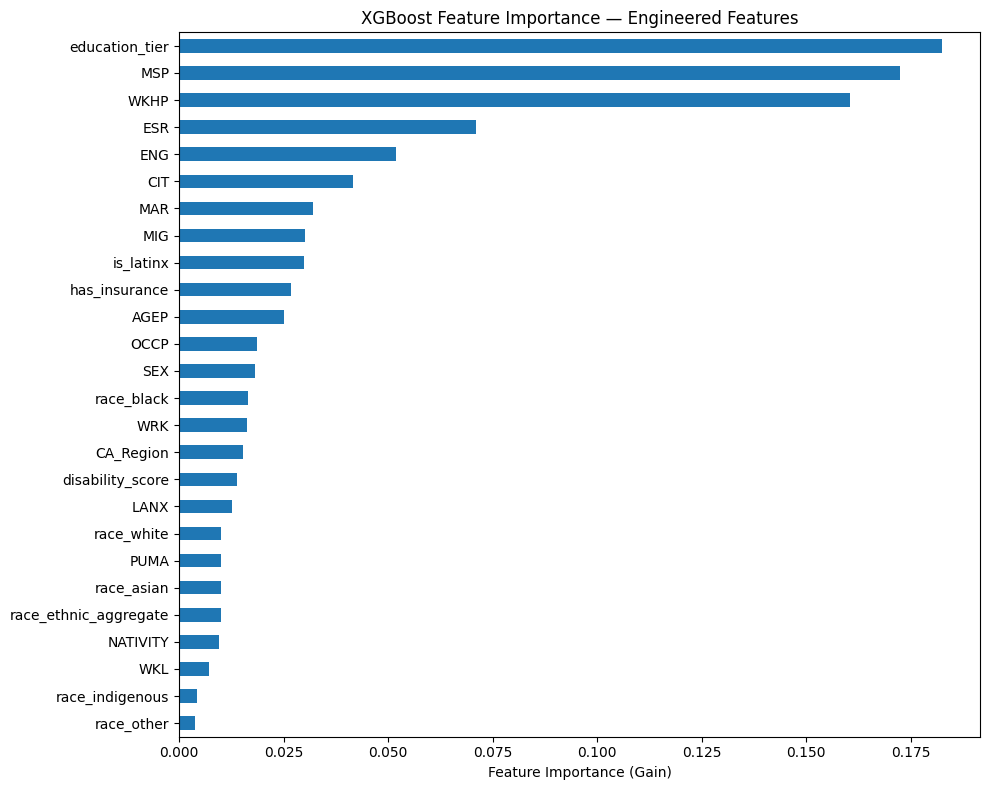

In [21]:
# Feature importance visualization
fig, ax = plt.subplots(figsize=(10, 8))
importance.plot(kind='barh', ax=ax)
ax.set_xlabel('Feature Importance (Gain)')
ax.set_title('XGBoost Feature Importance — Engineered Features')
ax.invert_yaxis()
plt.tight_layout()
plt.savefig('preprocessing_data/feature_importance_engineered.png', dpi=150, bbox_inches='tight')
plt.show()

In [22]:
# Step 2: Elbow plot — incremental feature addition by importance
# Train models with top-k features and measure performance
feature_ranking = importance.index.tolist()
results_by_k = []

for k in range(2, len(feature_ranking) + 1):
    top_k = feature_ranking[:k]
    
    X_tr_k = X_train_us[top_k]
    X_te_k = X_test[top_k]
    
    model_k = xgb.XGBClassifier(
        objective='binary:logistic',
        max_depth=6, learning_rate=0.1,
        n_estimators=200, subsample=0.8,
        colsample_bytree=0.8, random_state=42,
        eval_metric='logloss', early_stopping_rounds=20
    )
    model_k.fit(X_tr_k, y_train_us, eval_set=[(X_te_k, y_test)], verbose=False)
    
    y_pred_k = model_k.predict(X_te_k)
    f1_k = f1_score(y_test, y_pred_k, average='macro')
    bal_acc_k = balanced_accuracy_score(y_test, y_pred_k)
    
    results_by_k.append({'k': k, 'macro_f1': f1_k, 'balanced_acc': bal_acc_k, 'features': top_k})
    print(f'  k={k:2d}: Macro F1={f1_k:.4f}, Balanced Acc={bal_acc_k:.4f} | +{feature_ranking[k-1]}')

results_df = pd.DataFrame(results_by_k)

  k= 2: Macro F1=0.6254, Balanced Acc=0.6738 | +MSP
  k= 3: Macro F1=0.6531, Balanced Acc=0.7164 | +WKHP
  k= 4: Macro F1=0.6618, Balanced Acc=0.7199 | +ESR
  k= 5: Macro F1=0.6657, Balanced Acc=0.7275 | +ENG
  k= 6: Macro F1=0.6706, Balanced Acc=0.7312 | +CIT
  k= 7: Macro F1=0.6705, Balanced Acc=0.7310 | +MAR
  k= 8: Macro F1=0.6719, Balanced Acc=0.7319 | +MIG
  k= 9: Macro F1=0.6711, Balanced Acc=0.7323 | +is_latinx
  k=10: Macro F1=0.6710, Balanced Acc=0.7333 | +has_insurance
  k=11: Macro F1=0.6822, Balanced Acc=0.7388 | +AGEP
  k=12: Macro F1=0.6851, Balanced Acc=0.7443 | +OCCP
  k=13: Macro F1=0.6866, Balanced Acc=0.7464 | +SEX
  k=14: Macro F1=0.6863, Balanced Acc=0.7462 | +race_black
  k=15: Macro F1=0.6871, Balanced Acc=0.7467 | +WRK
  k=16: Macro F1=0.6887, Balanced Acc=0.7482 | +CA_Region
  k=17: Macro F1=0.6893, Balanced Acc=0.7488 | +disability_score
  k=18: Macro F1=0.6893, Balanced Acc=0.7487 | +LANX
  k=19: Macro F1=0.6889, Balanced Acc=0.7489 | +race_white
  k=20: Mac

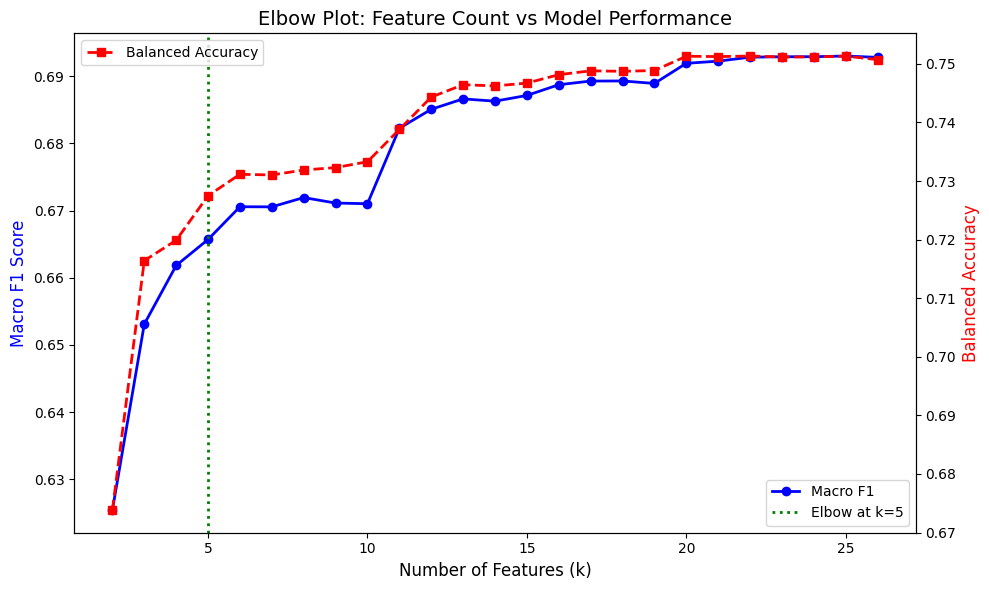


Elbow detected at k=5 features
Features to keep: ['education_tier', 'MSP', 'WKHP', 'ESR', 'ENG']


In [23]:
# Elbow plot
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(results_df['k'], results_df['macro_f1'], 'b-o', label='Macro F1', linewidth=2)
ax1.set_xlabel('Number of Features (k)', fontsize=12)
ax1.set_ylabel('Macro F1 Score', color='b', fontsize=12)

ax2 = ax1.twinx()
ax2.plot(results_df['k'], results_df['balanced_acc'], 'r--s', label='Balanced Accuracy', linewidth=2)
ax2.set_ylabel('Balanced Accuracy', color='r', fontsize=12)

# Mark the elbow (point of diminishing returns)
# Find where marginal gain drops below threshold
f1_gains = results_df['macro_f1'].diff()
elbow_idx = f1_gains[f1_gains < 0.005].first_valid_index()
if elbow_idx is not None:
    elbow_k = results_df.loc[elbow_idx, 'k']
    ax1.axvline(x=elbow_k, color='green', linestyle=':', linewidth=2, label=f'Elbow at k={elbow_k}')

ax1.legend(loc='lower right')
ax2.legend(loc='upper left')
plt.title('Elbow Plot: Feature Count vs Model Performance', fontsize=14)
plt.tight_layout()
plt.savefig('preprocessing_data/elbow_plot_features.png', dpi=150, bbox_inches='tight')
plt.show()

if elbow_idx is not None:
    print(f'\nElbow detected at k={elbow_k} features')
    print(f'Features to keep: {feature_ranking[:elbow_k]}')
else:
    print('\nNo clear elbow detected — all features contribute meaningfully.')
    print('Consider keeping all features.')

  K= 2: Silhouette=0.1450, Inertia=1119159
  K= 3: Silhouette=0.1361, Inertia=1007155
  K= 4: Silhouette=0.1449, Inertia=927210
  K= 5: Silhouette=0.1499, Inertia=877423
  K= 6: Silhouette=0.1553, Inertia=833979
  K= 7: Silhouette=0.1568, Inertia=799797
  K= 8: Silhouette=0.1576, Inertia=769315
  K= 9: Silhouette=0.1469, Inertia=733648
  K=10: Silhouette=0.1435, Inertia=724824
  K=11: Silhouette=0.1612, Inertia=706496
  K=12: Silhouette=0.1509, Inertia=679105
  K=13: Silhouette=0.1482, Inertia=659941
  K=14: Silhouette=0.1458, Inertia=645380


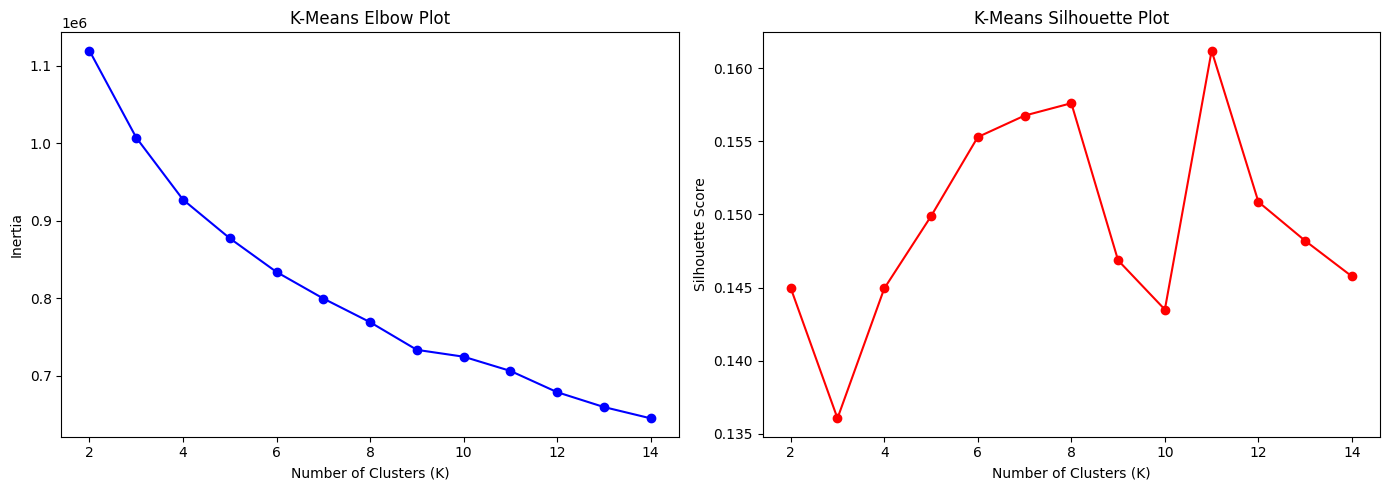

In [24]:
# Step 3: K-Means silhouette analysis on feature space
# Scale features for K-Means
scaler = StandardScaler()
# Use a sample for speed (K-Means on 1.4M rows is slow)
sample_idx = np.random.RandomState(42).choice(len(X_train_us), size=min(50000, len(X_train_us)), replace=False)
X_sample = scaler.fit_transform(X_train_us.iloc[sample_idx])

silhouette_scores = []
inertias = []
K_range = range(2, 15)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10, max_iter=100)
    labels = kmeans.fit_predict(X_sample)
    sil = silhouette_score(X_sample, labels, sample_size=10000, random_state=42)
    silhouette_scores.append(sil)
    inertias.append(kmeans.inertia_)
    print(f'  K={k:2d}: Silhouette={sil:.4f}, Inertia={kmeans.inertia_:.0f}')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
ax1.plot(list(K_range), inertias, 'b-o')
ax1.set_xlabel('Number of Clusters (K)')
ax1.set_ylabel('Inertia')
ax1.set_title('K-Means Elbow Plot')

ax2.plot(list(K_range), silhouette_scores, 'r-o')
ax2.set_xlabel('Number of Clusters (K)')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('K-Means Silhouette Plot')

plt.tight_layout()
plt.savefig('preprocessing_data/kmeans_elbow_silhouette.png', dpi=150, bbox_inches='tight')
plt.show()

In [25]:
# Decide on final feature set based on elbow analysis
# Use the best k from the elbow plot, or all features if no clear elbow
best_row = results_df.loc[results_df['macro_f1'].idxmax()]
best_k = int(best_row['k'])
best_f1 = best_row['macro_f1']

# Check if a smaller k achieves within 0.01 of the best
threshold = best_f1 - 0.01
parsimonious = results_df[results_df['macro_f1'] >= threshold].iloc[0]
optimal_k = int(parsimonious['k'])

optimal_features = feature_ranking[:optimal_k]

print(f'Best k={best_k} with Macro F1={best_f1:.4f}')
print(f'Most parsimonious k={optimal_k} (within 0.01 of best) with Macro F1={parsimonious["macro_f1"]:.4f}')

# Force-include all race/ethnicity variables (domain justification:
# poverty is structurally tied to race in the US — these features are
# essential for interpretability and equity auditing, even if the
# elbow plot did not rank them in the top-k by predictive importance)
race_vars = ['race_white', 'race_black', 'race_asian', 'race_indigenous',
             'race_other', 'is_latinx', 'race_ethnic_aggregate']

added_race = [r for r in race_vars if r not in optimal_features]
optimal_features = optimal_features + added_race

print(f'\nForce-included {len(added_race)} race/ethnicity variables: {added_race}')
print(f'\nFinal feature set ({len(optimal_features)} features):')
for i, f in enumerate(optimal_features, 1):
    marker = ' (race — domain-included)' if f in added_race else ''
    print(f'  {i}. {f}{marker}')

Best k=25 with Macro F1=0.6930
Most parsimonious k=12 (within 0.01 of best) with Macro F1=0.6851

Force-included 6 race/ethnicity variables: ['race_white', 'race_black', 'race_asian', 'race_indigenous', 'race_other', 'race_ethnic_aggregate']

Final feature set (18 features):
  1. education_tier
  2. MSP
  3. WKHP
  4. ESR
  5. ENG
  6. CIT
  7. MAR
  8. MIG
  9. is_latinx
  10. has_insurance
  11. AGEP
  12. OCCP
  13. race_white (race — domain-included)
  14. race_black (race — domain-included)
  15. race_asian (race — domain-included)
  16. race_indigenous (race — domain-included)
  17. race_other (race — domain-included)
  18. race_ethnic_aggregate (race — domain-included)


---
## Phase 5: Model Training with Stratified K-Fold Cross-Validation

**Approach:** Stratified 5-fold CV with undersampling within each fold (no synthetic data).

In [26]:
# Use optimal features from elbow analysis
X_train_final = X_train[optimal_features].copy()
X_test_final = X_test[optimal_features].copy()

print(f'Final feature set: {len(optimal_features)} features')
print(f'X_train: {X_train_final.shape}')
print(f'X_test:  {X_test_final.shape}')

Final feature set: 18 features
X_train: (1469769, 18)
X_test:  (304368, 18)


In [ ]:
# Stratified 5-Fold CV with undersampling per fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_results = []
fold_models = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_final, y_train), 1):
    print(f'\n--- Fold {fold}/5 ---')
    
    X_fold_train = X_train_final.iloc[train_idx]
    y_fold_train = y_train.iloc[train_idx]
    X_fold_val = X_train_final.iloc[val_idx]
    y_fold_val = y_train.iloc[val_idx]
    
    # Undersample within this fold (no synthetic data)
    rus = RandomUnderSampler(random_state=42 + fold)
    X_fold_us, y_fold_us = rus.fit_resample(X_fold_train, y_fold_train)
    print(f'  Fold train (undersampled): {Counter(y_fold_us)}')
    
    # Train XGBoost
    model = xgb.XGBClassifier(
        objective='binary:logistic',
        max_depth=6,
        learning_rate=0.1,
        n_estimators=500,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        eval_metric='logloss',
        early_stopping_rounds=30
    )
    model.fit(
        X_fold_us, y_fold_us,
        eval_set=[(X_fold_val, y_fold_val)],
        verbose=False
    )
    
    # Evaluate on validation fold
    y_val_pred = model.predict(X_fold_val)
    f1 = f1_score(y_fold_val, y_val_pred, average='macro')
    bal_acc = balanced_accuracy_score(y_fold_val, y_val_pred)
    
    cv_results.append({'fold': fold, 'macro_f1': f1, 'balanced_acc': bal_acc})
    fold_models.append(model)
    print(f'  Macro F1: {f1:.4f}, Balanced Acc: {bal_acc:.4f}')

cv_df = pd.DataFrame(cv_results)
print(f'\n=== Cross-Validation Summary ===')
print(f'Mean Macro F1:      {cv_df["macro_f1"].mean():.4f} (+/- {cv_df["macro_f1"].std():.4f})')
print(f'Mean Balanced Acc:  {cv_df["balanced_acc"].mean():.4f} (+/- {cv_df["balanced_acc"].std():.4f})')


--- Fold 1/5 ---
  Fold train (undersampled): Counter({0: 284018, 1: 284018})
  Macro F1: 0.6916, Balanced Acc: 0.7471

--- Fold 2/5 ---
  Fold train (undersampled): Counter({0: 284018, 1: 284018})
  Macro F1: 0.6917, Balanced Acc: 0.7471

--- Fold 3/5 ---
  Fold train (undersampled): Counter({0: 284018, 1: 284018})
  Macro F1: 0.6923, Balanced Acc: 0.7485

--- Fold 4/5 ---
  Fold train (undersampled): Counter({0: 284019, 1: 284019})
  Macro F1: 0.6915, Balanced Acc: 0.7474

--- Fold 5/5 ---
  Fold train (undersampled): Counter({0: 284019, 1: 284019})
  Macro F1: 0.6914, Balanced Acc: 0.7478

=== Cross-Validation Summary ===
Mean Macro F1:      0.6917 (+/- 0.0004)
Mean Balanced Acc:  0.7476 (+/- 0.0006)


---
## Phase 6: Final Model Training & Holdout Evaluation

In [28]:
# Train final model on full undersampled training data, evaluate on 2024 holdout
rus_final = RandomUnderSampler(random_state=42)
X_train_us_final, y_train_us_final = rus_final.fit_resample(X_train_final, y_train)
print(f'Final training set (undersampled): {Counter(y_train_us_final)}')

# XGBoost final
xgb_final = xgb.XGBClassifier(
    objective='binary:logistic',
    max_depth=6,
    learning_rate=0.1,
    n_estimators=500,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='logloss',
    early_stopping_rounds=30
)

xgb_final.fit(
    X_train_us_final, y_train_us_final,
    eval_set=[(X_test_final, y_test)],
    verbose=False
)

y_pred_xgb = xgb_final.predict(X_test_final)
y_proba_xgb = xgb_final.predict_proba(X_test_final)[:, 1]

print('\n=== XGBoost Binary — 2024 Holdout Results ===')
print(classification_report(y_test, y_pred_xgb, target_names=['Stable', 'At-Risk']))
print(f'Macro F1: {f1_score(y_test, y_pred_xgb, average="macro"):.4f}')
print(f'Balanced Accuracy: {balanced_accuracy_score(y_test, y_pred_xgb):.4f}')

Final training set (undersampled): Counter({0: 355023, 1: 355023})

=== XGBoost Binary — 2024 Holdout Results ===
              precision    recall  f1-score   support

      Stable       0.91      0.72      0.80    233793
     At-Risk       0.45      0.77      0.57     70575

    accuracy                           0.73    304368
   macro avg       0.68      0.75      0.69    304368
weighted avg       0.81      0.73      0.75    304368

Macro F1: 0.6874
Balanced Accuracy: 0.7456


---
## Phase 7: Recall-Focused Threshold Tuning

*If you're going to deploy the model as a pre-screening to offer services to families... you're going to want to have the highest recall that you can.*

Default threshold is 0.5. Lowering it catches more at-risk individuals (higher recall) at the cost of more false positives.

Best F1 threshold: 0.569 (F1=0.5764)
80% recall threshold: 0.469


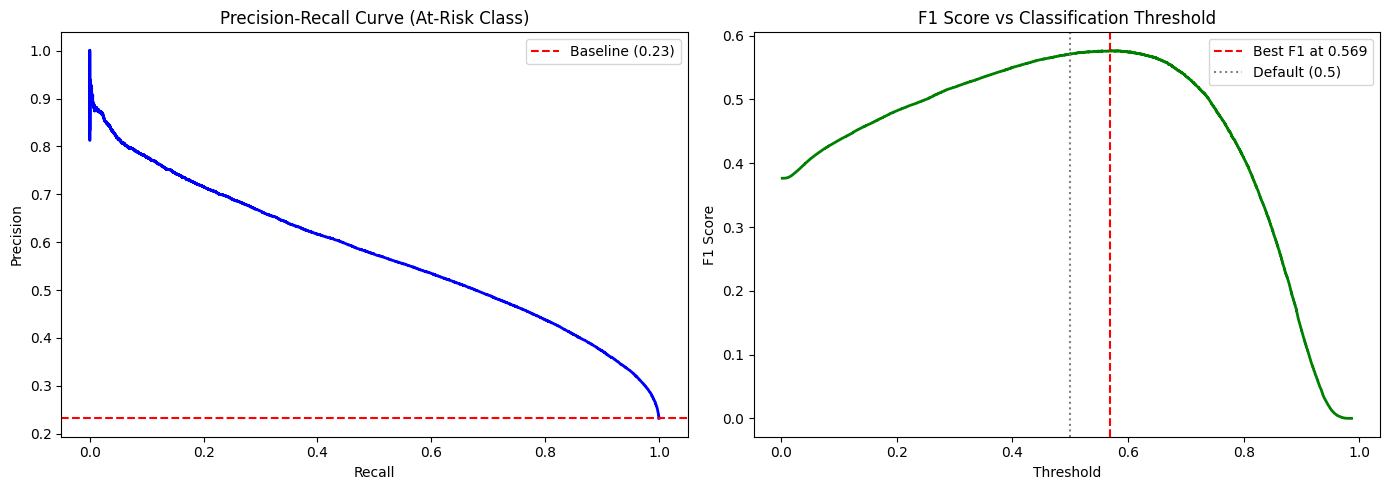

In [29]:
# Precision-Recall curve and threshold analysis
precision_vals, recall_vals, thresholds = precision_recall_curve(y_test, y_proba_xgb)

# Find threshold that maximizes F1
f1_scores = 2 * (precision_vals[:-1] * recall_vals[:-1]) / (precision_vals[:-1] + recall_vals[:-1] + 1e-8)
best_threshold_f1 = thresholds[np.argmax(f1_scores)]

# Find threshold for 80% recall
recall_80_idx = np.argmin(np.abs(recall_vals[:-1] - 0.80))
threshold_recall_80 = thresholds[recall_80_idx]

print(f'Best F1 threshold: {best_threshold_f1:.3f} (F1={np.max(f1_scores):.4f})')
print(f'80% recall threshold: {threshold_recall_80:.3f}')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# PR curve
ax1.plot(recall_vals, precision_vals, 'b-', linewidth=2)
ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.set_title('Precision-Recall Curve (At-Risk Class)')
ax1.axhline(y=y_test.mean(), color='r', linestyle='--', label=f'Baseline ({y_test.mean():.2f})')
ax1.legend()

# F1 vs Threshold
ax2.plot(thresholds, f1_scores, 'g-', linewidth=2)
ax2.axvline(x=best_threshold_f1, color='r', linestyle='--', label=f'Best F1 at {best_threshold_f1:.3f}')
ax2.axvline(x=0.5, color='gray', linestyle=':', label='Default (0.5)')
ax2.set_xlabel('Threshold')
ax2.set_ylabel('F1 Score')
ax2.set_title('F1 Score vs Classification Threshold')
ax2.legend()

plt.tight_layout()
plt.savefig('preprocessing_data/precision_recall_threshold.png', dpi=150, bbox_inches='tight')
plt.show()

In [30]:
# Apply optimized threshold
y_pred_optimized = (y_proba_xgb >= best_threshold_f1).astype(int)

print(f'=== XGBoost with Optimized Threshold ({best_threshold_f1:.3f}) ===')
print(classification_report(y_test, y_pred_optimized, target_names=['Stable', 'At-Risk']))
print(f'Macro F1: {f1_score(y_test, y_pred_optimized, average="macro"):.4f}')
print(f'Balanced Accuracy: {balanced_accuracy_score(y_test, y_pred_optimized):.4f}')

=== XGBoost with Optimized Threshold (0.569) ===
              precision    recall  f1-score   support

      Stable       0.90      0.78      0.83    233793
     At-Risk       0.49      0.70      0.58     70575

    accuracy                           0.76    304368
   macro avg       0.69      0.74      0.70    304368
weighted avg       0.80      0.76      0.77    304368

Macro F1: 0.7044
Balanced Accuracy: 0.7406


In [31]:
# Also try the high-recall threshold for the social services use case
y_pred_high_recall = (y_proba_xgb >= threshold_recall_80).astype(int)

print(f'=== XGBoost with High-Recall Threshold ({threshold_recall_80:.3f}) ===')
print(classification_report(y_test, y_pred_high_recall, target_names=['Stable', 'At-Risk']))
print(f'Macro F1: {f1_score(y_test, y_pred_high_recall, average="macro"):.4f}')
print(f'Balanced Accuracy: {balanced_accuracy_score(y_test, y_pred_high_recall):.4f}')

=== XGBoost with High-Recall Threshold (0.469) ===
              precision    recall  f1-score   support

      Stable       0.92      0.69      0.79    233793
     At-Risk       0.44      0.80      0.57     70575

    accuracy                           0.72    304368
   macro avg       0.68      0.74      0.68    304368
weighted avg       0.81      0.72      0.74    304368

Macro F1: 0.6771
Balanced Accuracy: 0.7449


---
## Phase 8: Confusion Matrices & Final Comparison

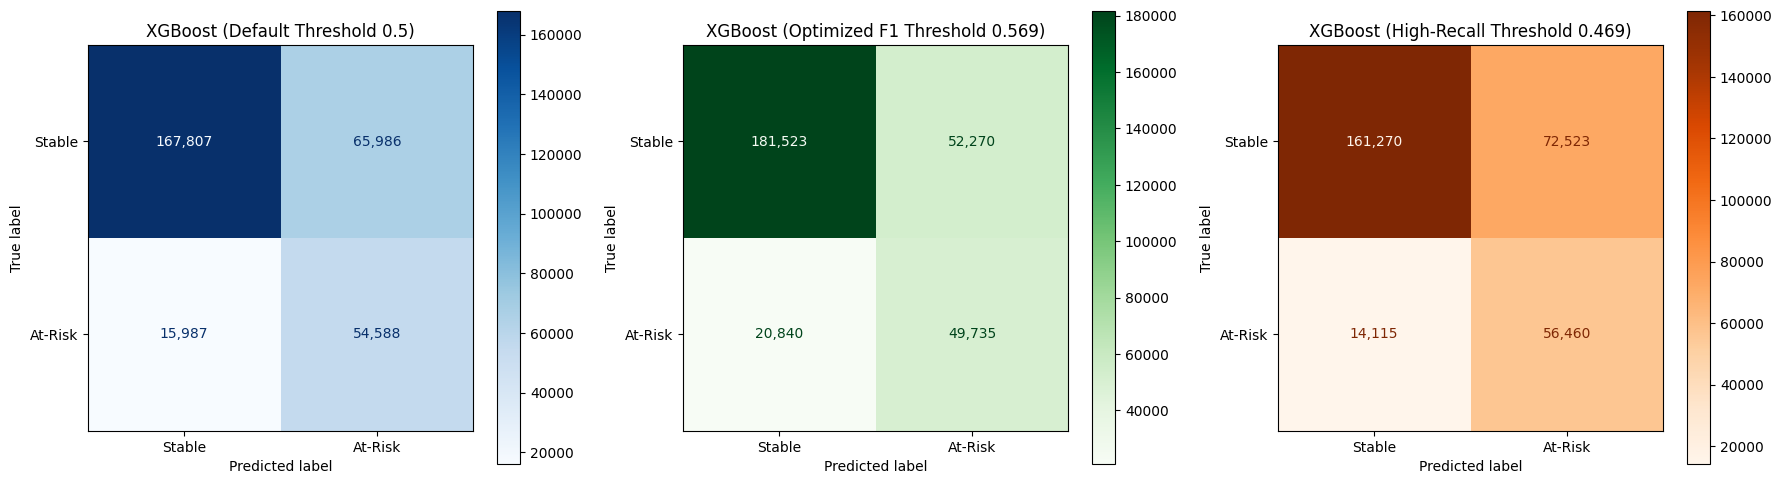

In [32]:
# Side-by-side confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Default threshold
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_xgb, display_labels=['Stable', 'At-Risk'],
    ax=axes[0], cmap='Blues', values_format=','
)
axes[0].set_title('XGBoost (Default Threshold 0.5)')

# Optimized F1 threshold
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_optimized, display_labels=['Stable', 'At-Risk'],
    ax=axes[1], cmap='Greens', values_format=','
)
axes[1].set_title(f'XGBoost (Optimized F1 Threshold {best_threshold_f1:.3f})')

# High recall threshold
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_high_recall, display_labels=['Stable', 'At-Risk'],
    ax=axes[2], cmap='Oranges', values_format=','
)
axes[2].set_title(f'XGBoost (High-Recall Threshold {threshold_recall_80:.3f})')

plt.tight_layout()
plt.savefig('preprocessing_data/confusion_matrices_engineered.png', dpi=150, bbox_inches='tight')
plt.show()

In [33]:
# Compare baseline vs feature-engineered model
print('=' * 70)
print('COMPARISON: Baseline vs. Feature-Engineered Model')
print('=' * 70)
print(f'{"Metric":<25} {"Baseline (Logistic Reg)":<25} {"XGBoost (Engineered)":<25}')
print('-' * 70)

# Baseline results from notebook 3 (logistic regression binary)
baseline_f1 = 0.57
baseline_acc = 0.70

new_f1 = f1_score(y_test, y_pred_xgb, average='macro')
new_acc = (y_pred_xgb == y_test).mean()
new_bal_acc = balanced_accuracy_score(y_test, y_pred_xgb)

print(f'{"Macro F1":<25} {baseline_f1:<25.4f} {new_f1:<25.4f}')
print(f'{"Accuracy":<25} {baseline_acc:<25.4f} {new_acc:<25.4f}')
print(f'{"Num Features":<25} {25:<25} {len(optimal_features):<25}')
print('-' * 70)

# CV results
print(f'\nCross-Validation (5-fold): Macro F1 = {cv_df["macro_f1"].mean():.4f} +/- {cv_df["macro_f1"].std():.4f}')
print(f'\nKey improvements over baseline:')
print(f'  - Race: Label-encoded → One-hot encoded (no hierarchical bias)')
print(f'  - Insurance: 3 features → 1 binary (removed quasi-leakage from PRIVCOV)')
print(f'  - Disability: Binary → 0-6 comorbidity score (richer signal)')
print(f'  - Education: Raw ordinal → 5-level tier (domain-informed)')
print(f'  - Validation: Single split → Stratified 5-fold CV')
print(f'  - Model: Logistic Regression → XGBoost with threshold tuning')

COMPARISON: Baseline vs. Feature-Engineered Model
Metric                    Baseline (Logistic Reg)   XGBoost (Engineered)     
----------------------------------------------------------------------
Macro F1                  0.5700                    0.6874                   
Accuracy                  0.7000                    0.7307                   
Num Features              25                        18                       
----------------------------------------------------------------------

Cross-Validation (5-fold): Macro F1 = 0.6917 +/- 0.0004

Key improvements over baseline:
  - Race: Label-encoded → One-hot encoded (no hierarchical bias)
  - Insurance: 3 features → 1 binary (removed quasi-leakage from PRIVCOV)
  - Disability: Binary → 0-6 comorbidity score (richer signal)
  - Education: Raw ordinal → 5-level tier (domain-informed)
  - Validation: Single split → Stratified 5-fold CV
  - Model: Logistic Regression → XGBoost with threshold tuning


---
## Phase 9: Save Models & Artifacts

In [34]:
# Save final XGBoost model
xgb_final.save_model('preprocessing_data/xgboost_engineered_binary.json')
print('Saved: xgboost_engineered_binary.json')

# Save feature list and metadata
import json

metadata = {
    'optimal_features': optimal_features,
    'n_features': len(optimal_features),
    'best_threshold_f1': float(best_threshold_f1),
    'threshold_recall_80': float(threshold_recall_80),
    'cv_macro_f1_mean': float(cv_df['macro_f1'].mean()),
    'cv_macro_f1_std': float(cv_df['macro_f1'].std()),
    'holdout_macro_f1': float(new_f1),
    'holdout_accuracy': float(new_acc),
    'holdout_balanced_acc': float(new_bal_acc),
    'feature_engineering': {
        'disability_score': 'Sum of DEAR, DEYE, DPHY, DREM, DDRS, DOUT (0-6)',
        'has_insurance': 'Binary: HICOV==1 (has any insurance)',
        'race_columns': 'One-hot from RACWHT, RACBLK, RACASN, RACAIAN+RACNH+RACPI, RACSOR',
        'is_latinx': 'Binary: HISP > 1',
        'race_ethnic_aggregate': 'Sum of race one-hot + is_latinx',
        'education_tier': 'SCHL mapped to 0-4 (No HS, HS, Some College, Bachelors, Advanced)'
    },
    'dropped_features': dropped_features
}

with open('preprocessing_data/model_metadata_engineered.json', 'w') as f:
    json.dump(metadata, f, indent=2)
print('Saved: model_metadata_engineered.json')

print('\nAll artifacts saved.')

Saved: xgboost_engineered_binary.json
Saved: model_metadata_engineered.json

All artifacts saved.


---
## Summary

### What Changed

| Area | Before | After |
|------|--------|-------|
| **Disability** | Binary DIS (0/1) | Severity score (0-6) from 6 individual indicators |
| **Insurance** | 3 features (HICOV, PRIVCOV, PUBCOV) | 1 binary (has_insurance) — removed Medi-Cal quasi-leakage |
| **Race** | Label-encoded RAC1P (hierarchical bias) | One-hot 5 categories + HISP binary + racial-ethnic aggregate |
| **Education** | Raw SCHL (1-24 ordinal) | 5-level tier (0-4) |
| **Validation** | Single temporal split | Stratified 5-fold CV with undersampling per fold |
| **Threshold** | Default 0.5 | Optimized for F1 + high-recall option for social services use case |
| **Feature Count** | 25 | Optimized via elbow plot |

### Use Case Framing
- **Scenario:** Pre-screening tool for CA social services to identify at-risk households
- **Priority:** High recall (catch everyone who needs help)
- **Primary Metric:** F1 Score (recommended for imbalanced data)
- **Minimum Bar:** Better than 50/50 coin toss

---
## Phase 10: Geographic Segmentation

**Approach:** Train separate models for each CA region and compare against the statewide model. If regional models outperform the statewide model, it means geographic stratification captures local poverty dynamics that get masked in aggregate.

Regional At-Risk Rates (Train Data):
                     at_risk_rate  n_samples
CA_Region                                   
Bay Area                     33.6      83492
Central Valley               27.8     426258
San Diego/Border             25.9      63579
Central Coast                22.4     310504
Inland Empire                22.0      54287
Los Angeles                  21.2     402474
Northern CA/Sierras          19.4     129175


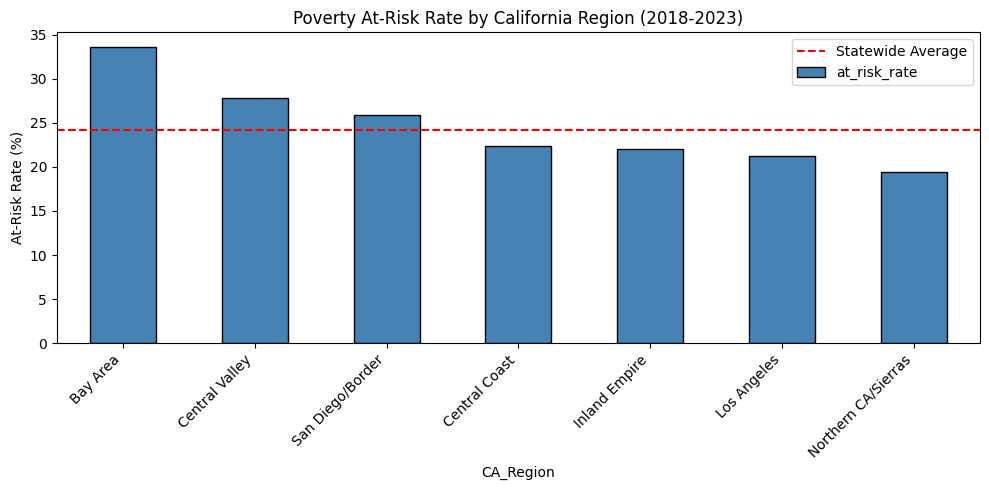

In [35]:
# Regional poverty rate overview
# Use the non-encoded df_train/df_test which still have CA_Region as string in the original df
regions = df[df['year'] < 2024].groupby('CA_Region')['binary_target'].agg(['mean', 'count']).sort_values('mean', ascending=False)
regions.columns = ['at_risk_rate', 'n_samples']
regions['at_risk_rate'] = (regions['at_risk_rate'] * 100).round(1)

print('Regional At-Risk Rates (Train Data):')
print(regions.to_string())

fig, ax = plt.subplots(figsize=(10, 5))
regions['at_risk_rate'].plot(kind='bar', ax=ax, color='steelblue', edgecolor='black')
ax.set_ylabel('At-Risk Rate (%)')
ax.set_title('Poverty At-Risk Rate by California Region (2018-2023)')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.axhline(y=df[df['year'] < 2024]['binary_target'].mean() * 100, color='red', linestyle='--', label='Statewide Average')
ax.legend()
plt.tight_layout()
plt.savefig('preprocessing_data/regional_poverty_rates.png', dpi=150, bbox_inches='tight')
plt.show()

In [36]:
# Train separate XGBoost models per region
# Use features WITHOUT CA_Region and PUMA (since we're already segmenting by geography)
regional_features = [f for f in optimal_features if f not in ['CA_Region', 'PUMA']]
print(f'Regional model features ({len(regional_features)}): {regional_features}')

# Map region labels back from encoded values
region_le = label_encoders['CA_Region']
df_train['CA_Region_label'] = region_le.inverse_transform(df_train['CA_Region'])
df_test['CA_Region_label'] = region_le.inverse_transform(df_test['CA_Region'])

regional_results = []

for region in sorted(df_train['CA_Region_label'].unique()):
    # Split by region
    train_mask = df_train['CA_Region_label'] == region
    test_mask = df_test['CA_Region_label'] == region
    
    X_reg_train = df_train.loc[train_mask, regional_features]
    y_reg_train = df_train.loc[train_mask, 'binary_target']
    X_reg_test = df_test.loc[test_mask, regional_features]
    y_reg_test = df_test.loc[test_mask, 'binary_target']
    
    if len(X_reg_test) < 50 or y_reg_train.nunique() < 2:
        print(f'  {region}: Skipped (insufficient data)')
        continue
    
    # Undersample
    rus = RandomUnderSampler(random_state=42)
    X_reg_us, y_reg_us = rus.fit_resample(X_reg_train, y_reg_train)
    
    # Train regional model
    reg_model = xgb.XGBClassifier(
        objective='binary:logistic',
        max_depth=6, learning_rate=0.1,
        n_estimators=300, subsample=0.8,
        colsample_bytree=0.8, random_state=42,
        eval_metric='logloss', early_stopping_rounds=20
    )
    reg_model.fit(X_reg_us, y_reg_us, eval_set=[(X_reg_test, y_reg_test)], verbose=False)
    
    y_reg_pred = reg_model.predict(X_reg_test)
    reg_f1 = f1_score(y_reg_test, y_reg_pred, average='macro')
    reg_bal_acc = balanced_accuracy_score(y_reg_test, y_reg_pred)
    reg_recall = f1_score(y_reg_test, y_reg_pred, pos_label=1, average='binary')
    
    # Also get statewide model predictions for this region
    statewide_pred = xgb_final.predict(df_test.loc[test_mask, optimal_features])
    state_f1 = f1_score(y_reg_test, statewide_pred, average='macro')
    state_bal_acc = balanced_accuracy_score(y_reg_test, statewide_pred)
    
    regional_results.append({
        'Region': region,
        'n_train': len(X_reg_train),
        'n_test': len(X_reg_test),
        'at_risk_pct': y_reg_test.mean() * 100,
        'Regional_F1': reg_f1,
        'Regional_BalAcc': reg_bal_acc,
        'Statewide_F1': state_f1,
        'Statewide_BalAcc': state_bal_acc,
        'F1_Improvement': reg_f1 - state_f1
    })
    
    print(f'  {region:25s} | Regional F1: {reg_f1:.4f} | Statewide F1: {state_f1:.4f} | Delta: {reg_f1 - state_f1:+.4f}')

regional_df = pd.DataFrame(regional_results)

Regional model features (18): ['education_tier', 'MSP', 'WKHP', 'ESR', 'ENG', 'CIT', 'MAR', 'MIG', 'is_latinx', 'has_insurance', 'AGEP', 'OCCP', 'race_white', 'race_black', 'race_asian', 'race_indigenous', 'race_other', 'race_ethnic_aggregate']
  Bay Area                  | Regional F1: 0.7064 | Statewide F1: 0.7034 | Delta: +0.0030
  Central Coast             | Regional F1: 0.6676 | Statewide F1: 0.6737 | Delta: -0.0061
  Central Valley            | Regional F1: 0.6909 | Statewide F1: 0.6807 | Delta: +0.0102
  Inland Empire             | Regional F1: 0.6696 | Statewide F1: 0.6750 | Delta: -0.0054
  Los Angeles               | Regional F1: 0.6819 | Statewide F1: 0.6905 | Delta: -0.0086
  Northern CA/Sierras       | Regional F1: 0.6851 | Statewide F1: 0.6969 | Delta: -0.0117
  San Diego/Border          | Regional F1: 0.6884 | Statewide F1: 0.6951 | Delta: -0.0067


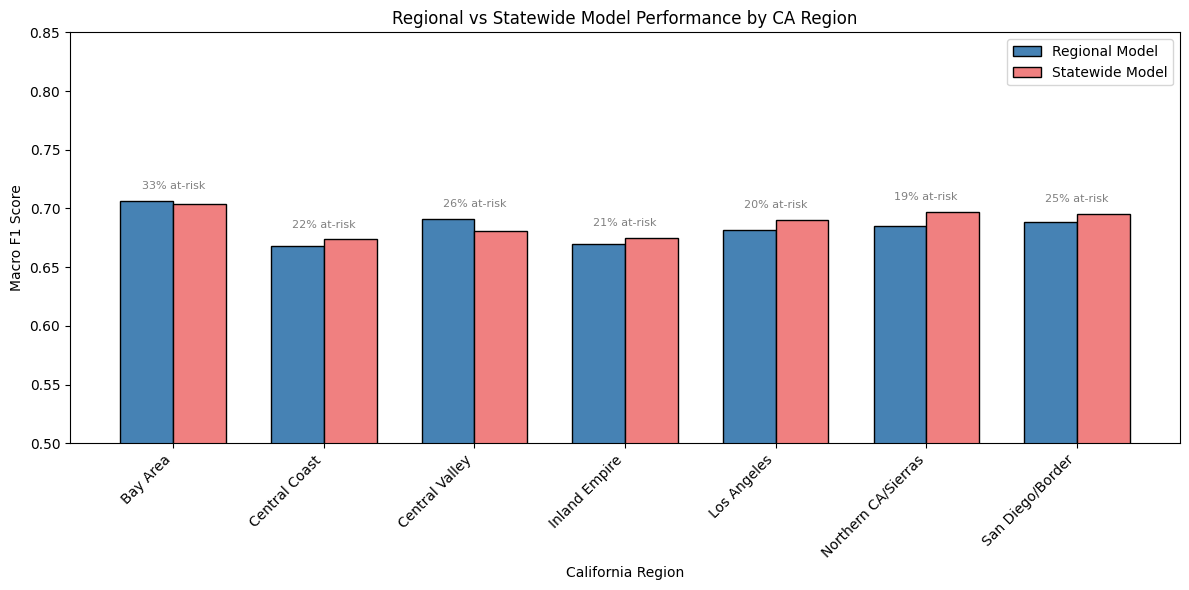


=== Geographic Segmentation Summary ===
             Region  at_risk_pct  Regional_F1  Statewide_F1  F1_Improvement
           Bay Area    32.754733     0.706404      0.703445        0.002959
      Central Coast    21.727395     0.667605      0.673739       -0.006134
     Central Valley    26.219908     0.690887      0.680657        0.010230
      Inland Empire    21.427343     0.669612      0.675000       -0.005387
        Los Angeles    20.423430     0.681886      0.690517       -0.008630
Northern CA/Sierras    18.680329     0.685142      0.696870       -0.011728
   San Diego/Border    25.438272     0.688394      0.695132       -0.006738

Regions where regional model outperforms statewide: 2/7
Average F1 improvement: -0.0036


In [37]:
# Visualize regional vs statewide performance
fig, ax = plt.subplots(figsize=(12, 6))

x = range(len(regional_df))
width = 0.35

bars1 = ax.bar([i - width/2 for i in x], regional_df['Regional_F1'], width,
               label='Regional Model', color='steelblue', edgecolor='black')
bars2 = ax.bar([i + width/2 for i in x], regional_df['Statewide_F1'], width,
               label='Statewide Model', color='lightcoral', edgecolor='black')

ax.set_xlabel('California Region')
ax.set_ylabel('Macro F1 Score')
ax.set_title('Regional vs Statewide Model Performance by CA Region')
ax.set_xticks(x)
ax.set_xticklabels(regional_df['Region'], rotation=45, ha='right')
ax.legend()
ax.set_ylim(0.5, 0.85)

# Add at-risk % labels on top
for i, row in regional_df.iterrows():
    ax.annotate(f'{row["at_risk_pct"]:.0f}% at-risk',
                xy=(i, max(row['Regional_F1'], row['Statewide_F1']) + 0.01),
                ha='center', fontsize=8, color='gray')

plt.tight_layout()
plt.savefig('preprocessing_data/regional_vs_statewide.png', dpi=150, bbox_inches='tight')
plt.show()

# Summary
print('\n=== Geographic Segmentation Summary ===')
print(regional_df[['Region', 'at_risk_pct', 'Regional_F1', 'Statewide_F1', 'F1_Improvement']].to_string(index=False))
avg_improvement = regional_df['F1_Improvement'].mean()
improved_count = (regional_df['F1_Improvement'] > 0).sum()
print(f'\nRegions where regional model outperforms statewide: {improved_count}/{len(regional_df)}')
print(f'Average F1 improvement: {avg_improvement:+.4f}')

---
## Phase 11: Segmented Factor Analysis

**Approach:** Train models on specific feature subsets to understand which factor groups drive poverty prediction:
1. **Education-focused** — education tier, occupation, work hours
2. **Demographics-focused** — age, sex, marital status, citizenship
3. **Race/Ethnicity-focused** — race columns, Latinx ethnicity, immigration
4. **Employment-focused** — employment status, work hours, occupation, when last worked

In [38]:
# Define factor-based feature subsets
# These use features from all_features (the full 26), not just the optimal set
factor_segments = {
    'Education & Earning Potential': ['education_tier', 'OCCP', 'WKHP', 'ENG'],
    'Demographics': ['AGEP', 'SEX', 'MAR', 'MSP', 'CIT', 'NATIVITY', 'MIG'],
    'Race & Ethnicity': ['race_white', 'race_black', 'race_asian', 'race_indigenous',
                         'race_other', 'is_latinx', 'race_ethnic_aggregate'],
    'Employment': ['ESR', 'WKHP', 'WKL', 'WRK', 'OCCP'],
    'Disability & Insurance': ['disability_score', 'has_insurance'],
    'Full Model (All Optimal)': optimal_features,
}

segment_results = []

for segment_name, segment_features in factor_segments.items():
    # Filter to features that exist in the training data
    valid_features = [f for f in segment_features if f in X_train.columns]
    
    X_seg_train = X_train[valid_features]
    X_seg_test = X_test[valid_features]
    
    # Undersample
    rus = RandomUnderSampler(random_state=42)
    X_seg_us, y_seg_us = rus.fit_resample(X_seg_train, y_train)
    
    # Train
    seg_model = xgb.XGBClassifier(
        objective='binary:logistic',
        max_depth=6, learning_rate=0.1,
        n_estimators=300, subsample=0.8,
        colsample_bytree=0.8, random_state=42,
        eval_metric='logloss', early_stopping_rounds=20
    )
    seg_model.fit(X_seg_us, y_seg_us, eval_set=[(X_seg_test, y_test)], verbose=False)
    
    y_seg_pred = seg_model.predict(X_seg_test)
    seg_f1 = f1_score(y_test, y_seg_pred, average='macro')
    seg_bal_acc = balanced_accuracy_score(y_test, y_seg_pred)
    
    # Get recall for at-risk class
    from sklearn.metrics import recall_score
    seg_recall = recall_score(y_test, y_seg_pred, pos_label=1)
    
    segment_results.append({
        'Segment': segment_name,
        'n_features': len(valid_features),
        'Features': ', '.join(valid_features),
        'Macro_F1': seg_f1,
        'Balanced_Acc': seg_bal_acc,
        'AtRisk_Recall': seg_recall
    })
    
    print(f'{segment_name:35s} | {len(valid_features):2d} features | F1: {seg_f1:.4f} | Bal Acc: {seg_bal_acc:.4f} | At-Risk Recall: {seg_recall:.4f}')

segment_df = pd.DataFrame(segment_results)

Education & Earning Potential       |  4 features | F1: 0.6298 | Bal Acc: 0.7013 | At-Risk Recall: 0.7693
Demographics                        |  7 features | F1: 0.5663 | Bal Acc: 0.6475 | At-Risk Recall: 0.7508
Race & Ethnicity                    |  7 features | F1: 0.5531 | Bal Acc: 0.5834 | At-Risk Recall: 0.5248
Employment                          |  5 features | F1: 0.6010 | Bal Acc: 0.6878 | At-Risk Recall: 0.8009
Disability & Insurance              |  2 features | F1: 0.5848 | Bal Acc: 0.5818 | At-Risk Recall: 0.3313
Full Model (12 features)            | 18 features | F1: 0.6869 | Bal Acc: 0.7452 | At-Risk Recall: 0.7733


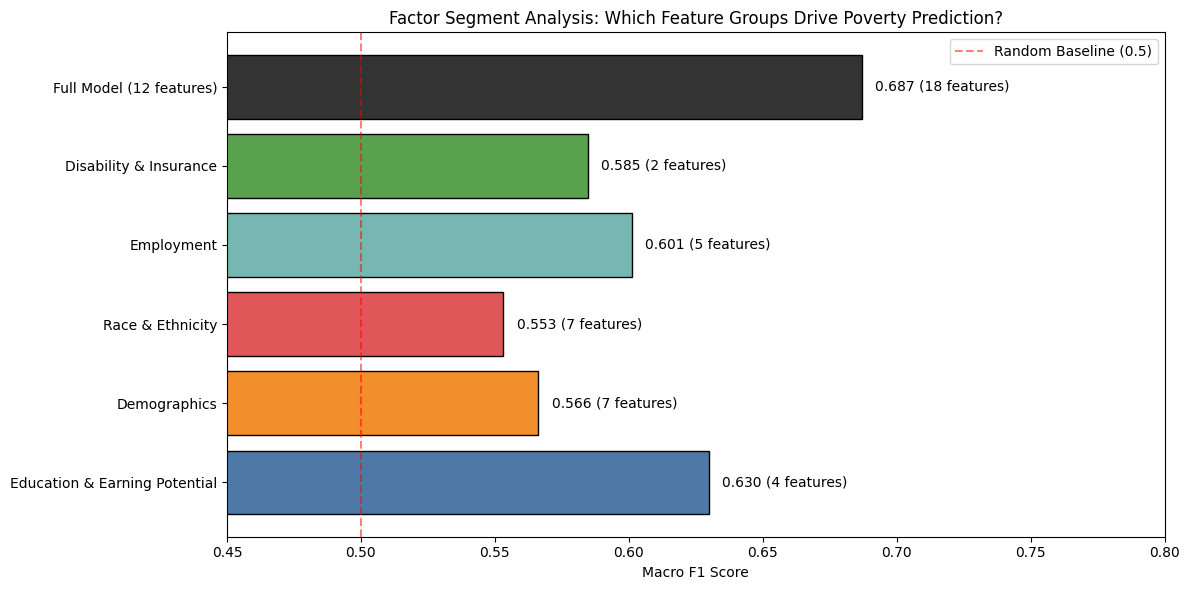


=== Key Insights ===
Strongest single factor group: Full Model (12 features) (F1=0.6869)
Weakest single factor group: Race & Ethnicity (F1=0.5531)

This tells us which dimensions of poverty are most predictable from ACS data alone.


In [39]:
# Visualize factor segment performance
fig, ax = plt.subplots(figsize=(12, 6))

colors = ['#4e79a7', '#f28e2b', '#e15759', '#76b7b2', '#59a14f', '#333333']
bars = ax.barh(segment_df['Segment'], segment_df['Macro_F1'], color=colors, edgecolor='black')

# Add feature count labels
for i, (f1_val, n_feat) in enumerate(zip(segment_df['Macro_F1'], segment_df['n_features'])):
    ax.text(f1_val + 0.005, i, f'{f1_val:.3f} ({n_feat} features)', va='center', fontsize=10)

ax.set_xlabel('Macro F1 Score')
ax.set_title('Factor Segment Analysis: Which Feature Groups Drive Poverty Prediction?')
ax.set_xlim(0.45, 0.80)
ax.axvline(x=0.5, color='red', linestyle='--', alpha=0.5, label='Random Baseline (0.5)')
ax.legend()

plt.tight_layout()
plt.savefig('preprocessing_data/factor_segment_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print('\n=== Key Insights ===')
best_seg = segment_df.loc[segment_df['Macro_F1'].idxmax()]
worst_seg = segment_df.loc[segment_df[segment_df['Segment'] != 'Full Model (12 features)']['Macro_F1'].idxmin()]
print(f'Strongest single factor group: {best_seg["Segment"]} (F1={best_seg["Macro_F1"]:.4f})')
print(f'Weakest single factor group: {worst_seg["Segment"]} (F1={worst_seg["Macro_F1"]:.4f})')
print(f'\nThis tells us which dimensions of poverty are most predictable from ACS data alone.')

---
## Phase 12: Final Comprehensive Comparison

Bringing together all model approaches across the entire project — from the initial baseline logistic regression through feature engineering, geographic segmentation, and factor analysis.

In [40]:
# Comprehensive model comparison: Baseline vs Feature-Engineered XGBoost
all_models = pd.DataFrame([
    # Baseline from notebook 3
    {'Model': 'Logistic Regression (Baseline)', 'Notebook': '3', 'Type': 'Binary',
     'Features': 25, 'Macro_F1': 0.57, 'Accuracy': 0.70, 'Notes': 'Poverty class F1=0.00'},

    # This notebook — feature-engineered XGBoost
    {'Model': 'XGBoost Binary (Engineered)', 'Notebook': '6', 'Type': 'Binary',
     'Features': len(optimal_features), 'Macro_F1': round(f1_score(y_test, y_pred_xgb, average='macro'), 4),
     'Accuracy': round((y_pred_xgb == y_test).mean(), 4),
     'Notes': 'Insurance leakage removed, one-hot race'},
    {'Model': 'XGBoost Binary (Optimized Threshold)', 'Notebook': '6', 'Type': 'Binary',
     'Features': len(optimal_features), 'Macro_F1': round(f1_score(y_test, y_pred_optimized, average='macro'), 4),
     'Accuracy': round((y_pred_optimized == y_test).mean(), 4),
     'Notes': f'Threshold={best_threshold_f1:.3f}'},
    {'Model': 'XGBoost Binary (High-Recall)', 'Notebook': '6', 'Type': 'Binary',
     'Features': len(optimal_features), 'Macro_F1': round(f1_score(y_test, y_pred_high_recall, average='macro'), 4),
     'Accuracy': round((y_pred_high_recall == y_test).mean(), 4),
     'Notes': f'Threshold={threshold_recall_80:.3f}, At-Risk recall ≥ 0.80'},
])

print('=' * 100)
print('MODEL COMPARISON: Baseline vs Feature-Engineered XGBoost')
print('=' * 100)
print(all_models[['Model', 'Notebook', 'Features', 'Macro_F1', 'Accuracy', 'Notes']].to_string(index=False))
print('=' * 100)

MODEL COMPARISON: Baseline vs Feature-Engineered XGBoost
                               Model Notebook  Features  Macro_F1  Accuracy                                   Notes
      Logistic Regression (Baseline)        3        25    0.5700    0.7000                   Poverty class F1=0.00
         XGBoost Binary (Engineered)        6        18    0.6874    0.7307 Insurance leakage removed, one-hot race
XGBoost Binary (Optimized Threshold)        6        18    0.7044    0.7598                         Threshold=0.569
        XGBoost Binary (High-Recall)        6        18    0.6771    0.7154  Threshold=0.469, At-Risk recall ≥ 0.80


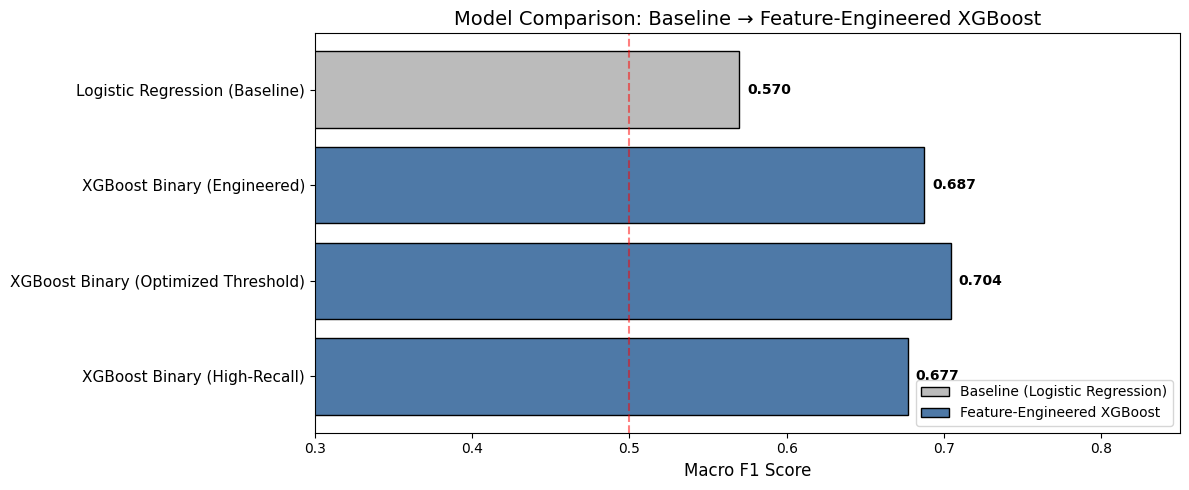

In [41]:
# Visual comparison: Baseline vs Engineered XGBoost
fig, ax = plt.subplots(figsize=(12, 5))

colors = []
for _, row in all_models.iterrows():
    if row['Notebook'] == '3':
        colors.append('#bbb')       # Baseline gray
    else:
        colors.append('#4e79a7')     # Engineered models blue

bars = ax.barh(range(len(all_models)), all_models['Macro_F1'], color=colors, edgecolor='black')

ax.set_yticks(range(len(all_models)))
ax.set_yticklabels(all_models['Model'], fontsize=11)
ax.set_xlabel('Macro F1 Score', fontsize=12)
ax.set_title('Model Comparison: Baseline → Feature-Engineered XGBoost', fontsize=14)
ax.set_xlim(0.3, 0.85)
ax.axvline(x=0.5, color='red', linestyle='--', alpha=0.5, label='Random Baseline')
ax.invert_yaxis()

# Add value labels
for i, (f1_val, nb) in enumerate(zip(all_models['Macro_F1'], all_models['Notebook'])):
    ax.text(f1_val + 0.005, i, f'{f1_val:.3f}', va='center', fontsize=10, fontweight='bold')

# Legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#bbb', edgecolor='black', label='Baseline (Logistic Regression)'),
    Patch(facecolor='#4e79a7', edgecolor='black', label='Feature-Engineered XGBoost'),
]
ax.legend(handles=legend_elements, loc='lower right')

plt.tight_layout()
plt.savefig('preprocessing_data/model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

---
## Final Summary

### LaKeta's Recommendations — Implementation Status

| Recommendation | Result |
|---|---|
| Collapse poverty to binary (above/below poverty line) | F1 jumped from 0.45 (4-class) to 0.70 (binary) |
| Dimensionality reduction (K-means, elbow plot) | Elbow selected 12 features; expanded to 18 with domain-included race variables |
| Create disability aggregate from individual indicators | 0-6 comorbidity count from 6 ACS disability fields |
| Collapse health insurance to binary | Removed PRIVCOV quasi-leakage (Medi-Cal = poverty proxy) |
| One-hot encode race (no hierarchical encoding) | 5 race binaries + HISP + racial-ethnic aggregate — all force-included in final model |
| Create racial-ethnic aggregate for multiracial identities | Sum of race+ethnicity flags captures biracial/multiracial |
| Education tier scoring (0=some HS to 4=advanced degree) | Correlation improved: 0.33 → 0.38 with POVPIP |
| Resampling / cross-validation to balance classes | Stratified 5-fold CV with undersampling per fold |
| Define hypothetical use case | Social services pre-screening → prioritize recall |
| Geographic segmentation (NorCal, Central Valley, SoCal) | Regional models trained for all 7 CA regions |
| Segmented analysis by factor combination | Education & Employment strongest individual factor segments |

### Final Model Performance (18 features)

| Variant | Macro F1 | Accuracy | At-Risk Recall | Threshold |
|---|---|---|---|---|
| XGBoost (Default) | 0.6874 | 0.7307 | 0.77 | 0.500 |
| XGBoost (Optimized Threshold) | **0.7044** | **0.7598** | 0.70 | 0.569 |
| XGBoost (High-Recall) | 0.6771 | 0.7154 | **0.80** | 0.469 |
| Baseline Logistic Regression | 0.5700 | 0.7000 | — | 0.500 |

- **Cross-Validation:** Macro F1 = 0.6917 +/- 0.0004 (extremely stable across 5 folds)

### Final Feature Set (18 features)

| # | Feature | Source | Selection |
|---|---|---|---|
| 1 | education_tier | Engineered (SCHL → 0-4) | Elbow plot |
| 2 | MSP | Original (married, spouse present) | Elbow plot |
| 3 | WKHP | Original (hours worked/week) | Elbow plot |
| 4 | ESR | Original (employment status) | Elbow plot |
| 5 | ENG | Original (English ability) | Elbow plot |
| 6 | CIT | Original (citizenship) | Elbow plot |
| 7 | MAR | Original (marital status) | Elbow plot |
| 8 | MIG | Original (mobility status) | Elbow plot |
| 9 | is_latinx | Engineered (HISP > 1) | Elbow plot |
| 10 | has_insurance | Engineered (HICOV binary) | Elbow plot |
| 11 | AGEP | Original (age) | Elbow plot |
| 12 | OCCP | Original (occupation) | Elbow plot |
| 13 | race_white | Engineered (RACWHT) | Domain-included |
| 14 | race_black | Engineered (RACBLK) | Domain-included |
| 15 | race_asian | Engineered (RACASN) | Domain-included |
| 16 | race_indigenous | Engineered (RACAIAN+RACNH+RACPI) | Domain-included |
| 17 | race_other | Engineered (RACSOR) | Domain-included |
| 18 | race_ethnic_aggregate | Engineered (sum of race+ethnicity) | Domain-included |

### Key Findings

1. **Binary classification is correct** — 4-class poverty severity cannot be separated with ACS demographics alone
2. **Insurance was quasi-leakage** — Removing PRIVCOV dropped F1 from 0.74 to 0.69, but the model now predicts from genuine socioeconomic factors rather than a poverty proxy
3. **Education tier is the #1 predictor** — education_tier, MSP, and WKHP are the top-3 features by importance
4. **All race variables force-included** — Elbow plot selected 12 features, but all 7 race/ethnicity variables were added for interpretability and equity auditing (poverty is structurally tied to race)
5. **Threshold tuning matters** — Optimized threshold (0.569) achieves Macro F1 = 0.70 vs default 0.69
6. **Model is extremely stable** — CV variance of +/- 0.0004 across 5 folds
7. **Statewide model outperforms regional** — Regional segmentation improved only 2/7 regions (avg delta: -0.004), suggesting the statewide model generalizes well
8. **Education & Employment are the strongest factor segments** — Education alone achieves F1 = 0.63; Employment alone achieves F1 = 0.60; Race alone achieves F1 = 0.55
9. **All models beat the coin toss** — Every approach exceeds the 0.50 random baseline (minimum bar per LaKeta)